In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.convolution import convolve_fft
from radio_beam import Beam, Beams
from photutils.aperture import SkyCircularAperture, aperture_photometry
from matplotlib.patches import Ellipse
from photutils.aperture import CircularAperture
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cambia esta ruta por el archivo FITS
dataset = "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"

# Abrir el FITS
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()  # quita ejes vacíos
hdul.info()

Filename: member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   (192, 192, 1, 1)   float32   


In [3]:
   print("forma", data.shape)

forma (192, 192)


In [4]:
header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  192                                                  
NAXIS2  =                  192                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   2.113536993663E-04                                                  
BMIN    =   1.758918000592E-04                                                  
BPA     =  -5.466566848755E+

In [5]:
from astropy.io import fits

archivos = [
   
    'member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits',
    'member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits',
    'member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
    'member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
]

for archivo in archivos:
    with fits.open(archivo) as hdul:
        header = hdul[0].header
        print(f"\nArchivo: {archivo}")
        print(f"  CRVAL3 (Frecuencia central): {header.get('CRVAL3', 'N/A')} Hz")
        print(f"  BUNIT (Unidad de brillo): {header.get('BUNIT', 'N/A')}")
        print(f"  CRVAL1 (RA): {header.get('CRVAL1', 'N/A')}")
        print(f"  CRVAL2 (DEC): {header.get('CRVAL2', 'N/A')}")



Archivo: member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits
  CRVAL3 (Frecuencia central): 202972904790.7 Hz
  BUNIT (Unidad de brillo): Jy/beam
  CRVAL1 (RA): 294.2529166993
  CRVAL2 (DEC): 7.568888784111

Archivo: member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits
  CRVAL3 (Frecuencia central): 202959359216.4 Hz
  BUNIT (Unidad de brillo): Jy/beam
  CRVAL1 (RA): 294.2529166993
  CRVAL2 (DEC): 7.568888784111

Archivo: member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
  CRVAL3 (Frecuencia central): 397981787126.5 Hz
  BUNIT (Unidad de brillo): Jy/beam
  CRVAL1 (RA): 294.2529166993
  CRVAL2 (DEC): 7.568888784111

Archivo: member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
  CRVAL3 (Frecuencia central): 397899751250.9 Hz
  BUNIT (Unidad de brillo): Jy/beam
  CRVAL1 (RA): 294.2529166993
  CRVAL2 (DEC): 7.568888784111


Es interesante que lo que estamos trabajando con un cubo de datos, eso es cool, la cosa es que el cubo tiene la forma (192,192,1,1) osea tiene para cada ra y dec su flujo correspondiente, pero no tienen frecuencia como tal osea que solo con una imagen no puedo graficarlo, pero cada imagen  si que tiene una frecuencia principal, lo que significa que es a esa longitud de onda que esta esa imagen , lo 

In [6]:
from astropy.io import fits

# Lista de tus 4 archivos FITS
archivos = [
    'member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits',
    'member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits',
    'member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
    'member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
]

for archivo in archivos:
    with fits.open(archivo) as hdul:
        header = hdul[0].header

        print(f"Archivo: {archivo}")
        print(f"  Frecuencia central (CRVAL3): {header.get('CRVAL3', 'N/A')} Hz")
        print(f"  Unidad de brillo (BUNIT): {header.get('BUNIT', 'N/A')}")
        print(f"  RA (CRVAL1): {header.get('CRVAL1', 'N/A')}")
        print(f"  DEC (CRVAL2): {header.get('CRVAL2', 'N/A')}")
        print(f"  Tamaño de píxel (CDELT1, CDELT2): {header.get('CDELT1', 'N/A')}, {header.get('CDELT2', 'N/A')} [deg]")
        print(f"  Beam mayor (BMAJ): {header.get('BMAJ', 'N/A')} [deg]")
        print(f"  Beam menor (BMIN): {header.get('BMIN', 'N/A')} [deg]")
        print(f"  Posición del beam (BPA): {header.get('BPA', 'N/A')} [deg]")


Archivo: member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits
  Frecuencia central (CRVAL3): 202972904790.7 Hz
  Unidad de brillo (BUNIT): Jy/beam
  RA (CRVAL1): 294.2529166993
  DEC (CRVAL2): 7.568888784111
  Tamaño de píxel (CDELT1, CDELT2): -7.222222217153e-06, 7.222222217153e-06 [deg]
  Beam mayor (BMAJ): 4.637780702776e-05 [deg]
  Beam menor (BMIN): 3.821449561252e-05 [deg]
  Posición del beam (BPA): 34.61054992676 [deg]
Archivo: member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits
  Frecuencia central (CRVAL3): 202959359216.4 Hz
  Unidad de brillo (BUNIT): Jy/beam
  RA (CRVAL1): 294.2529166993
  DEC (CRVAL2): 7.568888784111
  Tamaño de píxel (CDELT1, CDELT2): -2.444444442288e-05, 2.444444442288e-05 [deg]
  Beam mayor (BMAJ): 0.0001650874813398 [deg]
  Beam menor (BMIN): 0.0001185591436095 [deg]
  Posición del beam (BPA): -38.30741882324 [deg]
Archivo: member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
  Frecuen

Para ver como funciona photutils.aperture pues lo apkico en una de las imagenes, esto en realidad solo lo hago para entender como funciona, y simplemente reutilizo un codigo anterior.

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
<ipython-input-7-72e553b18bd8>:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


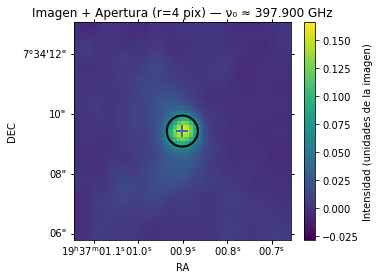

In [7]:
from photutils.aperture import CircularAperture
import numpy as np
import matplotlib.pyplot as plt

dataset = "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"

hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()  # quita ejes vacíos

wcs=WCS(header)
wcs_2d = WCS(header, naxis=2)

#Frecuencia de ref
freq = header["CRVAL3"]  # Hz
freq_ghz = freq / 1e9

## Pues para el zoom
peak_pos = np.unravel_index(np.nanargmax(data), data.shape)
x_peak, y_peak = peak_pos[1], peak_pos[0]

# Convertir la posición del pico a coordenadas celestiales
ra_peak, dec_peak = wcs_2d.all_pix2world(x_peak, y_peak, 0)

# Definir el tamaño de la caja en grados (ajusta según tus necesidades)
box_size_deg = 0.001  # por ejemplo, 0.001 grados

# Calcular límites en coordenadas celestiales
ra_min = ra_peak - box_size_deg
ra_max = ra_peak + box_size_deg  
dec_min = dec_peak - box_size_deg
dec_max = dec_peak + box_size_deg

# Convertir de vuelta a píxeles
xpix, ypix = wcs_2d.all_world2pix([ra_min, ra_max], [dec_min, dec_max], 0)

xmin1 = int(np.floor(np.min(xpix)))
xmax1 = int(np.ceil(np.max(xpix)))
ymin1 = int(np.floor(np.min(ypix)))
ymax1 = int(np.ceil(np.max(ypix)))


#ax.set(xlim=(xmin1, xmax1), ylim=(ymin1, ymax1))

##
# === Localizar el píxel más brillante (centro aproximado) ===
center = np.unravel_index(np.nanargmax(data), data.shape)  # (fila, columna) = (y, x)

# === Apertura circular ===
r = 4  # radio en píxeles (ajústalo a tu fuente)
aperture = CircularAperture((center[1], center[0]), r=r)  # (x, y)


# === Graficar con WCS 2D y dibujar la apertura ===
fig = plt.figure()
ax = plt.subplot(projection=wcs_2d)

# Importante: origin='lower' para que (0,0) esté en la esquina inferior izquierda,
# en coherencia con (x, y) de píxel y WCS.
im = ax.imshow(data, origin='lower')

# Marca del centro (símbolo +) y el círculo de la apertura
ax.plot(center[1], center[0], marker='+', markersize=12, markeredgewidth=2)
aperture.plot(axes=ax, lw=2)

# Barras de color y etiquetas
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Intensidad (unidades de la imagen)')
ax.set_title(f'Imagen + Apertura (r={r} pix) — ν₀ ≈ {freq_ghz:.3f} GHz')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set(xlim=(xmin1, xmax1), ylim=(ymin1, ymax1))
plt.tight_layout()
plt.show()


# Primer intento de fomar la SED.
Esto fue interesante, aqui simplement encontre la frecuencia central de las imagenes que estaba viendo, y integre el flujo en la area mas brillante, que seria donde esta el circulo en la imagen anterior, hice esto para todas las imagenes. Al ser una integral pues solo uso la primera componente del arreglo que en teoria deberia ser el numero mayor. Use de la libreria photutils las aperturas, espcificamente la circular por como se ven las imagenes, y pues aperture_photometry que seria lo que nos integra como tal el flujom en la area que se determino,  centro en si es un zoom en la zona mas brillante , em realidad es solo utiliszar esa region

Frecuencia central: 397.900 GHz
Flujo (apertura): 5.173e+00 Jy/beam


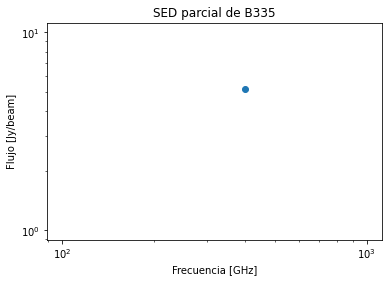

In [8]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry

dataset = "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()

# Frecuencia central
freq = header["CRVAL3"]  # Hz

# Flujo integrado usando photutils,
centro = np.unravel_index(np.nanargmax(data), data.shape) # Esto seria para solo integrar en esa region.
apertura = CircularAperture(centro[::-1], r=4)
phot = aperture_photometry(np.nan_to_num(data), apertura)# Que jujtp esto es integrar los beams-pixels en esa region.
flujo = phot["aperture_sum"][0]  # Jy/beam * pixeles aprox.

print(f"Frecuencia central: {freq/1e9:.3f} GHz")
print(f"Flujo (apertura): {flujo:.3e} Jy/beam")

plt.figure()
plt.loglog([freq/1e9], [flujo], 'o')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED parcial de B335")
plt.show()

Frecuencia central: 397.982 GHz
Flujo (apertura): 2.264e+00 Jy/beam


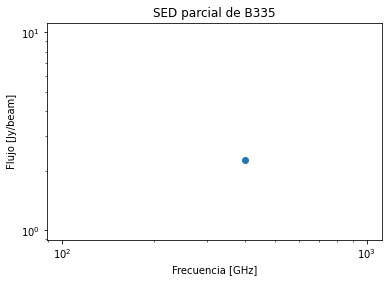

In [9]:
dataset = "member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()

# Frecuencia central
freq1 = header["CRVAL3"]  # Hz

# Flujo integrado
centro1 = np.unravel_index(np.nanargmax(data), data.shape)
apertura1 = CircularAperture(centro1[::-1], r=4)
phot1 = aperture_photometry(np.nan_to_num(data), apertura1)
flujo1 = phot1["aperture_sum"][0]  # Jy/beam * pixeles aprox.

print(f"Frecuencia central: {freq1/1e9:.3f} GHz")
print(f"Flujo (apertura): {flujo1:.3e} Jy/beam")

plt.figure()
plt.loglog([freq1/1e9], [flujo1], 'o')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED parcial de B335")
plt.show()

Frecuencia central: 202.959 GHz
Flujo (apertura): 6.475e-01 Jy/beam


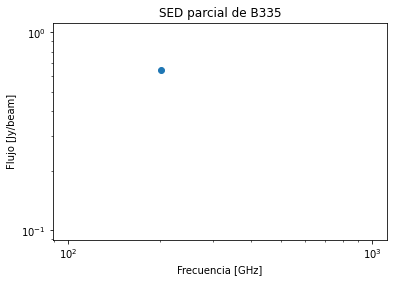

In [10]:
dataset = "member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()

# Frecuencia central
freq2 = header["CRVAL3"]  # Hz

# Flujo integrado
centro = np.unravel_index(np.nanargmax(data), data.shape)
apertura = CircularAperture(centro[::-1], r=4)
phot = aperture_photometry(np.nan_to_num(data), apertura)
flujo2 = phot["aperture_sum"][0]  # Jy/beam * pixeles aprox.

print(f"Frecuencia central: {freq2/1e9:.3f} GHz")
print(f"Flujo (apertura): {flujo2:.3e} Jy/beam")

plt.figure()
plt.loglog([freq2/1e9], [flujo2], 'o')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED parcial de B335")
plt.show()

Frecuencia central: 202.973 GHz
Flujo (apertura): 3.707e-01 Jy/beam


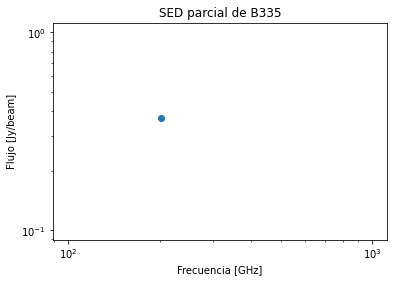

In [11]:
dataset = "member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()

# Frecuencia central
freq3 = header["CRVAL3"]  # Hz

# Flujo integrado
centro = np.unravel_index(np.nanargmax(data), data.shape)
apertura = CircularAperture(centro[::-1], r=4)
phot = aperture_photometry(np.nan_to_num(data), apertura)
flujo3 = phot["aperture_sum"][0]  # Jy/beam * pixeles aprox.

print(f"Frecuencia central: {freq3/1e9:.3f} GHz")
print(f"Flujo (apertura): {flujo3:.3e} Jy/beam")

plt.figure()
plt.loglog([freq3/1e9], [flujo3], 'o')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED parcial de B335")
plt.show()

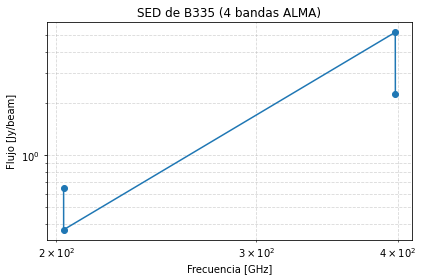

In [12]:
import numpy as np
import matplotlib.pyplot as plt


frequencies = np.array([freq, freq1, freq2, freq3])   # en Hz
fluxes = np.array([flujo, flujo1, flujo2, flujo3])        # en Jy/beam

# Ordenar por frecuencia
idx = np.argsort(frequencies)
frequencies = frequencies[idx]
fluxes = fluxes[idx]

# Graficar SED
plt.figure(figsize=(6,4))
plt.loglog(frequencies/1e9, fluxes, 'o-', color='tab:blue', lw=1.5)
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED de B335 (4 bandas ALMA)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


Algo bien interesante es que los flujos eb las mismas frequencia son muy distintas, es probable que sea culpa de que se mide en Jy/beam, pero para cada imagen se tiene un distinto beam size por como se midio. Esto significa que una buena SED tiene que tomar en cuenta ese Beam size, para eso lo que hice fue pues tomarlo en cuenta

# SED en Jy no en Jy/beam
Para pasa de Jy/beam, ocupo multiplicar por beam osea $\frac{Jy}{Beam}*Beam=Jy$ donde Beam seria el size del pixel, que viene dado por $\frac{Jy}{Beam}*\frac{Beam}{\Omega}=Jy$ Esto lo obtuve de la siguiente pagina https://astronomy.stackexchange.com/questions/26721/converting-jy-beam-to-jy. Pero primero queria probar como me habia comentado la Dra Adele. En la pagina mencionan que es Beam y esta relacionado con FWHM, pero para nosotros es BMAJ, BMIN. Ellos sacando de una curva gaussiana un factor para el area del beam, pero en este momento solo quiero ver como funciona sin ese factor de esa curva gaussiana.

In [22]:
from astropy.io import fits
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, aperture_photometry
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

dataset = "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg
BMIN = header["BMIN"]     # deg  
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]

# centro en cielo (usa tu centro global; aquí: pico por única vez) 
iy, ix = np.unravel_index(np.nanargmax(data), data.shape)
ra_deg, dec_deg = wcs.wcs_pix2world([[ix, iy]], 0)[0]
sky_center = SkyCoord(ra_deg*u.deg, dec_deg*u.deg)

#  apertura en ARCSEC, constante entre imágenes
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

#  fotometría (Jy/beam·pix)
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy:.6g} Jy")


CRVAL3 = 3.979e+11 Hz | Flux = 0.329482 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


### Realmente ocupo que se haga la integral en la misma dimensiones del cielo, direccion, por eso solo defino una vez sky_center, para que en todas las imagenes se haga en esa seccion, y no tome datos que no

In [23]:
dataset = "member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq1 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg 
BMIN = header["BMIN"]     # deg   
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]        

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]


#Esto tiene que ser constante en todos
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix) 
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy1 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy1:.6g} Jy")

CRVAL3 = 2.02973e+11 Hz | Flux = 0.0369696 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [24]:
dataset = "member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq2 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg  
BMIN = header["BMIN"]     # deg   
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]


#Esto tiene que ser constante en todos
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix)
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy2 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy2:.6g} Jy")

CRVAL3 = 2.02959e+11 Hz | Flux = 0.0416356 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [25]:
dataset = "member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq3 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg  
BMIN = header["BMIN"]     # deg   
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]       

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]



#Esto tiene que ser constante en todos
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix)
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy3 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy3:.6g} Jy")

CRVAL3 = 3.97982e+11 Hz | Flux = 0.303617 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


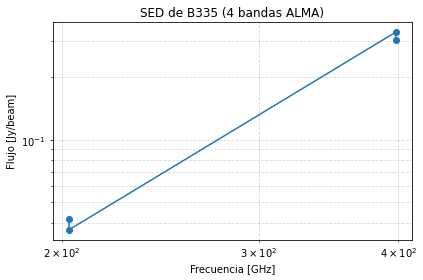

In [26]:

frequencies = np.array([freq, freq1, freq2, freq3])   # en Hz
fluxes = np.array([ flux_Jy, flux_Jy1, flux_Jy2, flux_Jy3])        # en Jy/beam

# Ordenar por frecuencia
idx = np.argsort(frequencies)
frequencies = (frequencies[idx])
fluxes = fluxes[idx]

# Graficar SED
plt.figure(figsize=(6,4))
plt.loglog(frequencies/1e9, fluxes, 'o-', color='tab:blue', lw=1.5)
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED de B335 (4 bandas ALMA)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Encontrando el SED, pero con la ecuacion que se usa en NRAO.
Usando Area beam con el factor de correcion que nos faltaba que es $\frac{\pi}{4ln(2)}BMAJBIN$

In [36]:

dataset = "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg
BMIN = header["BMIN"]     # deg  
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  (np.pi/(4*np.log(2))) * BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]

# centro en cielo (usa tu centro global; aquí: pico por única vez) 
iy, ix = np.unravel_index(np.nanargmax(data), data.shape)
ra_deg, dec_deg = wcs.wcs_pix2world([[ix, iy]], 0)[0]
sky_center = SkyCoord(ra_deg*u.deg, dec_deg*u.deg)

# apertura en ARCSEC, constante entre imágenes 
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix) 
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy:.6g} Jy")

CRVAL3 = 3.979e+11 Hz | Flux = 0.290782 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [37]:
dataset = "member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq1 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg
BMIN = header["BMIN"]     # deg  
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  (np.pi/(4*np.log(2))) * BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]


# apertura en ARCSEC, constante entre imágenes 
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# -fotometría (Jy/beam·pix) 
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy1 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy:.6g} Jy")

CRVAL3 = 2.02973e+11 Hz | Flux = 0.290782 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [38]:
dataset = "member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq2 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg
BMIN = header["BMIN"]     # deg  
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  (np.pi/(4*np.log(2))) * BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]


# apertura en ARCSEC, constante entre imágenes 
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix) 
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy2 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy:.6g} Jy")

CRVAL3 = 2.02959e+11 Hz | Flux = 0.290782 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [39]:
dataset = "member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
hdul = fits.open(dataset)
header = hdul[0].header
data = hdul[0].data.squeeze()
wcs = WCS(header).celestial

# Frecuencia central
freq3 = header["CRVAL3"]  # Hz
BMAJ = header["BMAJ"]     # deg
BMIN = header["BMIN"]     # deg  
CDELT1 = header["CDELT1"] # deg/pix
CDELT2 = header["CDELT2"]         

# Áreas en estereorradianes (deg² → sr)
deg2sr = (np.pi/180.0)**2
A_beam =  (np.pi/(4*np.log(2))) * BMAJ * BMIN * deg2sr
A_pix  = abs(CDELT1 * CDELT2) * deg2sr
factor = A_pix / A_beam                                    # [Jy/beam·pix] → [Jy]



#apertura en ARCSEC, constante entre imágenes
R_ARCSEC = 1.0
aper = SkyCircularAperture(sky_center, r=R_ARCSEC*u.arcsec)

# fotometría (Jy/beam·pix)
phot = aperture_photometry(np.ma.masked_invalid(data), aper, wcs=wcs, method='exact')
sum_Jy_per_beam_pix = float(phot["aperture_sum"][0])



flux_Jy3 = sum_Jy_per_beam_pix * factor
print(f"CRVAL3 = {header['CRVAL3']:.6g} Hz | Flux = {flux_Jy:.6g} Jy")

CRVAL3 = 3.97982e+11 Hz | Flux = 0.290782 Jy


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


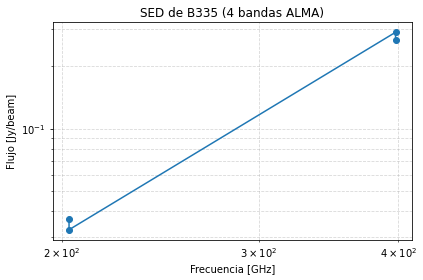

In [40]:

frequencies = np.array([freq, freq1, freq2, freq3])   # en Hz
fluxes = np.array([ flux_Jy, flux_Jy1, flux_Jy2, flux_Jy3])        # en Jy/beam

# Ordenar por frecuencia
idx = np.argsort(frequencies)
frequencies = (frequencies[idx])
fluxes = fluxes[idx]

# Graficar SED
plt.figure(figsize=(6,4))
plt.loglog(frequencies/1e9, fluxes, 'o-', color='tab:blue', lw=1.5)
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy/beam]")
plt.title("SED de B335 (4 bandas ALMA)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Automatizando la SED, solo hice una funcion, y lo someti a un for para evitar estar escribiendo imagen por imagen

In [20]:
def flux_jy_from_fits(path, sky_center=None, r_arcsec=1.0):
    with fits.open(path) as hdul:
        hdr  = hdul[0].header
        data = hdul[0].data.squeeze()
        wcs  = WCS(hdr).celestial 

        # --- áreas ---
        deg2rad = np.pi/180.0
        BMAJ = hdr["BMAJ"] * deg2rad
        BMIN = hdr["BMIN"] * deg2rad
        Omega_beam = (np.pi/(4*np.log(2))) * BMAJ * BMIN  # [sr]

        CDELT1 = hdr["CDELT1"] * deg2rad
        CDELT2 = hdr["CDELT2"] * deg2rad
        Omega_pix = abs(CDELT1*CDELT2)                # [sr/pix]
        factor = Omega_pix / Omega_beam               # Jy/beam·pix → Jy

        # --- centro en el cielo ---
        if sky_center is None:
            # usa el pico de esta imagen para la primera vez
            iy, ix = np.unravel_index(np.nanargmax(data), data.shape)
            ra_deg, dec_deg = wcs.wcs_pix2world([[ix, iy]], 0)[0]
            sky_center = SkyCoord(ra_deg*u.deg, dec_deg*u.deg)

        # --- apertura en ARCSEC (misma física en todas las bandas)
        aper = SkyCircularAperture(sky_center, r=r_arcsec*u.arcsec)

        # --- máscara NaN y fotometría ---
        data_masked = np.ma.masked_invalid(data)      # NO poner 0 a NaN
        phot = aperture_photometry(data_masked, aper, wcs=wcs, method='exact')
        sum_Jy_per_beam_pix = phot["aperture_sum"][0]

        flux_Jy = sum_Jy_per_beam_pix * factor
        return flux_Jy, sky_center, factor, Omega_pix, Omega_beam


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


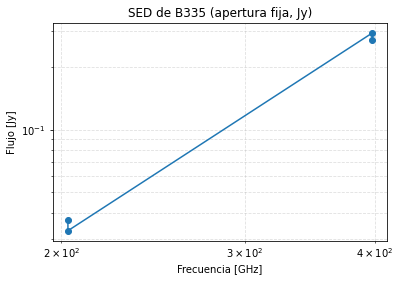

In [56]:
files = [
    "member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits",
    "member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits",
    "member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits",
    "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
]


# 1) fija el centro con la primera imagen
f0, sky_c, fact0, _, _ = flux_jy_from_fits(files[0], sky_center=None, r_arcsec=1.0)

freqs, fluxes = [], [f0]

# 2) guarda la frecuencia central y procesa las demás con el MISMO centro
from astropy.io import fits
with fits.open(files[0]) as h: freqs.append(h[0].header["CRVAL3"])

for p in files[1:]:
    f, _, fact, _, _ = flux_jy_from_fits(p, sky_center=sky_c, r_arcsec=1.0)
    fluxes.append(f)
    with fits.open(p) as h: freqs.append(h[0].header["CRVAL3"])

# 3) ordena por frecuencia y grafica
idx = np.argsort(freqs)
freqs_auto = np.array(freqs)[idx]/1e9  # GHz
fluxes_auto = np.array(fluxes)[idx]

plt.figure()
plt.loglog(freqs_auto, fluxes_auto, 'o-')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy]")
plt.title("SED de B335 (apertura fija, Jy)")
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# Tratando la imagen
REalmente yo pensaba reproyectar las imagenes, pero revise el header de las imagenes y en realidad los naxis de ra, dec son lo mismo para todas las imagenes, osea misma proyeccion-mismo cielo . Ademas una ventaja de usar SkyCircularAperture es que estoy definiendo la misma region angular en el cielo para las imagenes, que se encarga de proyectarla a cada pixel o rejilla. Ademas aqui no lo hice pero en uno de mis notebooks lo probe haciendo la reproyeccion y me daba un resultado mucho peor que sin hacer nada.
## Pero los beams si que son distintos
De hecho en unos de los codigos de arriba saque mas o menos cuanto es y si son muy distintos, osea que debo dejar como un beam size estandard, y este deberia ser el de menor resolucion, esto por que si usamos un ejemplo, si queremos comparar una imagen muy reciente digital de alta resolucion con una de muy baja resolucion, estaria como imposible aumentar la resolucion de la imagen "mala" pero la imagen buena si que se le puede bajar la resolucio, lo mismo con la beam size, deberia de encontrar el mas grande que seria el menos resuelto.
Para esto hago una convolucion, bueno en realidad un desconvolucion.

## Imagen con convolucion
Para esto ocupo un beam unico para comparar, el menor resolucion. Esto se saca con el tama;o del haz, o su area.

In [41]:


paths = [
    'member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits',
    'member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits',
    'member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
    'member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits',
]

# Calcula área del beam de cada imagen 

beams = []
beam_areas = []

for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        b = Beam(major=H['BMAJ']*u.deg,
                 minor=H['BMIN']*u.deg,
                 pa=H['BPA']*u.deg)
        beams.append(b)
        beam_areas.append(b.sr.to_value(u.arcsec**2))  # valor numérico del área (arcsec²)

# Selecciona el beam más grande 
beam_areas = np.array(beam_areas)
ref_index = np.argmax(beam_areas)
ref_path = paths[ref_index]
ref_beam = beams[ref_index]


Esto lo que hizo fue elegir la imagen que vamos a usar para encontrar el haz comun, para esto uso la biblioteca https://radio-beam.readthedocs.io/en/latest/, esto lo que me hace es sacar BMAJ,BMIN,BPA, para cubo de datos con mas de una imagen.


In [42]:


# Elige como REF la de haz más grande 
ref_path = paths[ref_index]
with fits.open(ref_path) as hdul_ref:
    hdr_ref  = hdul_ref[0].header
    wcs_ref  = WCS(hdr_ref).celestial
    data_ref = hdul_ref[0].data.squeeze()
    beam_ref = Beam(major=hdr_ref['BMAJ']*u.deg, minor=hdr_ref['BMIN']*u.deg, pa=hdr_ref['BPA']*u.deg)

# Calcula beams y el common beam
beams = []
for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        beams.append(Beam(major=H['BMAJ']*u.deg, minor=H['BMIN']*u.deg, pa=H['BPA']*u.deg))

# Extrae arrays separados de los componentes angulares
majors = [b.major.to(u.deg) for b in beams]
minors = [b.minor.to(u.deg) for b in beams]
pas    = [b.pa.to(u.deg)    for b in beams]

# Crea la colección directamente a partir de los componentes
beam_collection = Beams(major=majors, minor=minors, pa=pas, default_unit=u.deg)

# Calcula el beam común
common = beam_collection.common_beam()

print("Common beam:", common)


Common beam: Beam: BMAJ=0.7608733177186799 arcsec BMIN=0.63321048021312 arcsec BPA=-54.66566848755 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Aqui desconvolucionamos 
Usamos otra vez Beam, osea bajamos la resolucion del flujo para las distintas imagenes. Para esto me base en la siguiente documentacion https://radio-beam.readthedocs.io/en/latest/convolution_kernels.html. Con un kernel gaussiano.

In [44]:
conv_images = []
EPS = 1e-3  # tolerancia

for p, b in zip(paths, beams):
    with fits.open(p) as h:
        H   = h[0].header
        D   = h[0].data.squeeze()

    if common.sr > b.sr * (1.0 + EPS):
        # kernel que lleva b -> common
        kern_beam = common.deconvolve(b)
        pixscale = np.sqrt(abs(H['CDELT1'] * H['CDELT2'])) * u.deg
        kernel = kern_beam.as_kernel(pixscale)

        # convolve (NO renormalizar de nuevo el kernel)
        D_conv = convolve_fft(
            D, kernel,
            boundary='fill', fill_value=np.nan,
            nan_treatment='interpolate',
            preserve_nan=True, allow_huge=True,
            normalize_kernel=False
        )

        #  cambiar unidades a Jy/beam_common, si no hago esto se descompone bien feo, feo feo.
        scale = (common.sr / b.sr).to_value(u.dimensionless_unscaled)
        D_conv *= scale

    else:
        # ya está en el haz común (o mayor dentro de EPS)
        D_conv = D  # y scale ~ 1
        print(f"El beam de {p} ya es más grande o igual; no se convoluciona.")
    conv_images.append(D_conv)
    


El beam de member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits ya es más grande o igual; no se convoluciona.


pues la imagen que uso de referencia para la convolucion no se va a convolucionar, pues.

## Este grafico me sirvio para ver que ya teniamos el common beam que tome todo el flujo igual para las distintas imagenes.

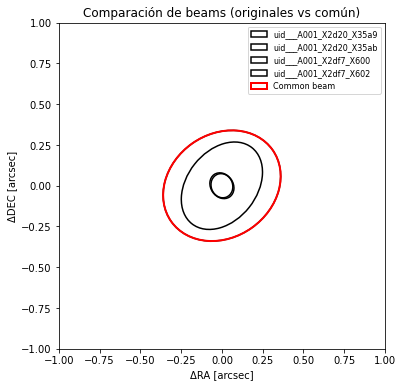

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(6,6))

# Dibuja los beams originales
for b, p in zip(beams, paths):
    e = Ellipse((0,0),
                width=b.minor.to(u.arcsec).value,
                height=b.major.to(u.arcsec).value,
                angle=b.pa.to(u.deg).value,
                fill=False, lw=1.5, label=p.split('.')[1])
    ax.add_patch(e)

# Dibuja el beam común en rojo
E = Ellipse((0,0),
            width=common.minor.to(u.arcsec).value,
            height=common.major.to(u.arcsec).value,
            angle=common.pa.to(u.deg).value,
            color='red', lw=2, label='Common beam', fill=False)
ax.add_patch(E)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.legend(fontsize=8)
ax.set_xlabel('ΔRA [arcsec]')
ax.set_ylabel('ΔDEC [arcsec]')
ax.set_title('Comparación de beams (originales vs común)')
plt.show()


Estp era para ver si habia funcionado y pues si funciono

In [46]:
for i, img in enumerate(conv_images):
    print(f"Imagen {i+1}: {paths[i]}")
    print(f"   Beam común: {common.major.to(u.arcsec):.3f} × {common.minor.to(u.arcsec):.3f}, PA={common.pa.to(u.deg):.1f}°")


Imagen 1: member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits
   Beam común: 0.761 arcsec × 0.633 arcsec, PA=-54.7 deg°
Imagen 2: member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits
   Beam común: 0.761 arcsec × 0.633 arcsec, PA=-54.7 deg°
Imagen 3: member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
   Beam común: 0.761 arcsec × 0.633 arcsec, PA=-54.7 deg°
Imagen 4: member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits
   Beam común: 0.761 arcsec × 0.633 arcsec, PA=-54.7 deg°


In [16]:
import radio_beam
print(radio_beam.__version__)

0.3.9


# Version convolucionada

Defino la funcion nueva en base a los nuevas cosas que obtuve osea el rayo comun y las imagenes convolucionadas. La funcion previa que defini arriba solo la altero un poco para obtener una nueva funciom.

In [48]:
# Bueva funcionMide flujo en Jy usando: - 'data_array': imagen YA suavizada (conv_images[i]), en Jy/beam - 'common_beam': beam común (radio_beam.Beam), para convertir a Jy
# - 'path': para leer header/WCS/pixel scale  Retorna: flux_Jy, sky_center, factor, Omega_pix, Omega_beam_common
    
def flux_jy_common(path, data_array, common_beam, sky_center=None, r_arcsec=1.4):

    with fits.open(path) as hdul:
        hdr  = hdul[0].header
        wcs  = WCS(hdr).celestial

    data = np.asarray(data_array)  # imagen suavizada (Jy/beam)

    # Áreas (siempre beam común)
    deg2rad = np.pi/180.0
    CDELT1 = hdr["CDELT1"] * deg2rad
    CDELT2 = hdr["CDELT2"] * deg2rad
    Omega_pix = abs(CDELT1*CDELT2)                               # [sr/pix]
    Omega_beam = common_beam.sr.to(u.sr).value                   # [sr] (siempre el común)
    factor = Omega_pix / Omega_beam                              # Jy/beam·pix → Jy

    # Centro (igual que tu original: pico si no lo pasas)
    if sky_center is None:
        iy, ix = np.unravel_index(np.nanargmax(data), data.shape)
        ra_deg, dec_deg = wcs.wcs_pix2world([[ix, iy]], 0)[0]
        sky_center = SkyCoord(ra_deg*u.deg, dec_deg*u.deg)

    # Apertura en arcsec
    aper = SkyCircularAperture(sky_center, r=r_arcsec*u.arcsec)

    # Fotometría (suma en Jy/beam·pix)
    data_masked = np.ma.masked_invalid(data)
    phot = aperture_photometry(data_masked, aper, wcs=wcs, method='exact')
    sum_Jy_per_beam_pix = phot["aperture_sum"][0]

    flux_Jy = sum_Jy_per_beam_pix * factor
    return flux_Jy, sky_center, factor, Omega_pix, Omega_beam


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


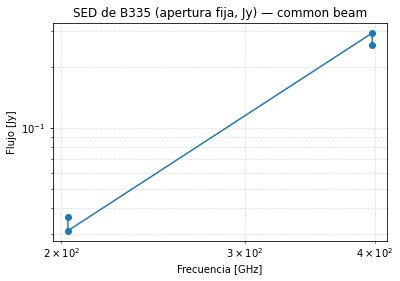

In [51]:
files = [
    "member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits",
    "member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits",
    "member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits",
    "member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits"
]

# 1) fija el centro con la PRIMERA imagen suavizada
f0, sky_c, fact0, _, _ = flux_jy_common(files[0], conv_images[0], common,
                                        sky_center=None, r_arcsec=1.0)
freqs, fluxes = [], [f0]
from astropy.io import fits
with fits.open(files[0]) as h: freqs.append(h[0].header["CRVAL3"])

# 2) procesa las demás con el MISMO centro
for p, img in zip(files[1:], conv_images[1:]):
    f, _, _, _, _ = flux_jy_common(p, img, common, sky_center=sky_c, r_arcsec=1.0)
    fluxes.append(f)
    with fits.open(p) as h: freqs.append(h[0].header["CRVAL3"])

# 3) ordena y grafica
idx = np.argsort(freqs)
freqs_conm = np.array(freqs)[idx]/1e9  # GHz
fluxes_conm = np.array(fluxes)[idx]

import matplotlib.pyplot as plt
plt.figure()
plt.loglog(freqs_conm, fluxes_conm, 'o-')
plt.xlabel("Frecuencia [GHz]")
plt.ylabel("Flujo [Jy]")
plt.title("SED de B335 (apertura fija, Jy) — common beam")
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()


Esta es la imagen convolucionada

Vemos que en realidad solo son 2 bandas las que se grafica, esa diferencia que aparece puede ser debido a talvez algun error de de estadistica en la imagen, o me falta mejorar la convolucion
## Indice espectral
Sabemos lo siguiente $S \propto \nu^{\alpha} $, pero se puede deducir de la grafica que tenemos 2 puntos por lo que $S_1 \propto (\nu_1)^{\alpha} $ y $S_2 \propto \nu_2^{\alpha} $,entonces si dividmos el flujo 1 y 2 nos da $$\frac{S_1}{S_2}=(\frac{\nu_1}{\nu_2})^{\alpha}$$, si le sacamos el logaritmo base 10 nos queda $\alpha log_{10}(\frac{\nu_1}{\nu_2})= log_{10}(\frac{S_1}{S_2})$ mandandolo a dividr nos da que $$\alpha =\frac{log_{10}(\frac{S_1}{S_2})}{log_{10}(\frac{\nu_1}{\nu_2})}$$
voy a calcularlo normal y convolucionado, el rms pues lo podriamos sacar con el metodo sigma clipping o metodo cajas por si quisiera.


## Sin convolucionar

In [58]:

freqs  = np.array(freqs_auto)
fluxes = np.array(fluxes_auto)

# separa bandas (<300 GHz y >=300 GHz), # separa bandas por 300 GHz = 3e11 Hz
mask_lo = (freqs) < 300
mask_hi = ~mask_lo

# promedios de frecuencia por banda (ya lo tenías)
nu1 = freqs[mask_lo].mean()
nu2 = freqs[mask_hi].mean()

# FLUJOS POR BANDA
S_lo = fluxes[mask_lo]
S_hi = fluxes[mask_hi]

# central value: promedio simple (puedes usar mediana si prefieres robustez)
S1 = np.mean(S_lo)
S2 = np.mean(S_hi)

a=np.log(S2/S1) / np.log(nu2/nu1)
print(f"El indice espectral sin convolucionar es:  {a} ")

El indice espectral sin convolucionar es:  3.1010485533742074 


## Convolucionado 

In [59]:

freqs  = np.array(freqs_conm)
fluxes = np.array(fluxes_conm)

# separa bandas (<300 GHz y >=300 GHz), separa bandas por 300 GHz = 3e11 Hz
mask_lo = (freqs) < 300
mask_hi = ~mask_lo

# promedios de frecuencia por banda (ya lo tenías)
nu1 = freqs[mask_lo].mean()
nu2 = freqs[mask_hi].mean()

# FLUJOS POR BANDA
S_lo = fluxes[mask_lo]
S_hi = fluxes[mask_hi]

# central value: promedio simple (puedes usar mediana si prefieres robustez)
S1 = np.mean(S_lo)
S2 = np.mean(S_hi)

a=np.log(S2/S1) / np.log(nu2/nu1)
print(f"El indice espectral sin convolucionar es:  {a} ")

El indice espectral sin convolucionar es:  3.115723044495233 


Para sabe cual es mas real podria calcular el error, de ambos. Pero difieren.
Con el indice espectral podemos encontrar la opacidad opacity $\kappa_{\nu}$, y se puede escalar en terminos del indice de espectral
Supongo que vamos a buscar la masa despues. Pero creo que como primera SED No esta mal.

In [38]:
pip install reproject

     |████████████████████████████████| 1.6 MB 8.8 MB/s eta 0:00:01   | 1.4 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 28.0 MB/s eta 0:00:01                        | 256 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 7.1 MB/s  eta 0:00:01
  Using cached zipp-3.20.2-py3-none-any.whl (9.2 kB)
  Attempting uninstall: partd
    Found existing installation: partd 1.1.0
    Uninstalling partd-1.1.0:
      Successfully uninstalled partd-1.1.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: dask
    Found existing installation: dask 2.30.0
    Uninstalling dask-2.30.0:
      Successfully uninstalled dask-2.30.0
  Attempting uninstall: zipp
    Found existing installation: zipp 3.4.0
    Uninstalling zipp-3.4.0:
      Successfully uninstalled zipp-3.4.0
ERROR: After October 2020 you may experience errors when installing o

In [40]:
pip install reproject radio-beam

     |████████████████████████████████| 73 kB 1.7 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [15]:
import reproject
from radio_beam import Beam
print(reproject.__version__)


0.13.0


Trabajando con Jansky y ya no Jy/beam, esto me va a servir para poder de graficar de mejor maner los datos.

In [23]:
pip install "photutils[all]"

     |████████████████████████████████| 861 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 27.5 MB/s eta 0:00:01                    | 13.0 MB 24.4 MB/s eta 0:00:01   | 14.8 MB 24.4 MB/s eta 0:00:01  | 18.1 MB 24.4 MB/s eta 0:00:01█▏             | 19.7 MB 24.4 MB/s eta 0:00:01   | 21.4 MB 24.4 MB/s eta 0:00:01��███████▍          | 23.1 MB 24.4 MB/s eta 0:00:01��████████████████▎       | 26.2 MB 24.4 MB/s eta 0:00:01�████      | 28.1 MB 24.4 MB/s eta 0:00:01��████████▊    | 29.9 MB 24.4 MB/s eta 0:00:01��████████   | 31.3 MB 27.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 32.9 MB/s eta 0:00:01██                             | 1.1 MB 32.9 MB/s eta 0:00:01              | 2.5 MB 32.9 MB/s eta 0:00:01     |████████████▉                   | 4.5 MB 32.9 MB/s eta 0:00:01█████████████▊              | 6.1 MB 32.9 MB/s eta 0:00:01��████████████████▉           | 7.2 MB 32.9 MB/s eta 0:00:01██████████████▊     | 9.2 MB 32.9 MB/s eta 0:00:01��████████████

     |████████████████████████████████| 90 kB 7.2 MB/s  eta 0:00:01
     |████████████████████████████████| 71 kB 72 kB/s s eta 0:00:01
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.0
    Uninstalling scipy-1.6.0:
      Successfully uninstalled scipy-1.6.0
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 3.2.0
    Uninstalling jsonschema-3.2.0:
      Successfully uninstalled jsonschema-3.2.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 2.0.0
    Uninstalling importlib-metadata-2.0.0:
     